# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:
url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


**1.2:**  How will your solution be used?


**1.3:**  How should success (or failure) be measured?


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [3]:
zillow_df = df.copy()
zillow_df.shape

(77613, 55)

In [4]:
zillow_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [5]:
zillow_df.airconditioningtypeid.value_counts()

airconditioningtypeid
1.0     23186
13.0     1575
5.0       167
11.0       53
9.0        26
Name: count, dtype: int64

In [6]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [7]:
zillow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,77613.0,1.300781e+07,3.518717e+06,1.071186e+07,1.153821e+07,1.253004e+07,1.421101e+07,1.676893e+08
airconditioningtypeid,25007.0,1.812013e+00,2.965768e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,207.0,7.386473e+00,2.728030e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77579.0,2.298496e+00,9.967317e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77579.0,3.053223e+00,1.140480e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49809.0,6.533779e+00,1.722062e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76963.0,2.316392e+00,9.796893e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,614.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [8]:
missing = zillow_df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)).round(3)
missing_summary = pd.DataFrame({'Total Nulls': missing, 'Pct': missing_pct})
print(missing_summary[missing_summary['Pct'] > 0.5])

                          Total Nulls    Pct
buildingclasstypeid             77598  1.000
finishedsquarefeet13            77571  0.999
basementsqft                    77563  0.999
storytypeid                     77563  0.999
yardbuildingsqft26              77543  0.999
fireplaceflag                   77441  0.998
architecturalstyletypeid        77406  0.997
typeconstructiontypeid          77390  0.997
finishedsquarefeet6             77227  0.995
pooltypeid10                    77148  0.994
decktypeid                      76999  0.992
poolsizesum                     76744  0.989
pooltypeid2                     76539  0.986
hashottuborspa                  76074  0.980
yardbuildingsqft17              75220  0.969
taxdelinquencyyear              74713  0.963
taxdelinquencyflag              74713  0.963
finishedsquarefeet15            74586  0.961
finishedsquarefeet50            71576  0.922
finishedfloor1squarefeet        71576  0.922
fireplacecnt                    69324  0.893
threequart

In [9]:
zillow_df.select_dtypes('object').nunique().sort_values(ascending=False)

propertyzoningdesc           1907
propertycountylandusecode      75
hashottuborspa                  1
fireplaceflag                   1
taxdelinquencyflag              1
dtype: int64

In [10]:
print(zillow_df.propertyzoningdesc.sample(10))

61737    DOR15000*
61977          NaN
24010     WVR320U*
49510          NaN
65473          NaN
24757          NaN
67930          NaN
12521          NaN
56060          NaN
34063       ALRPD*
Name: propertyzoningdesc, dtype: object


In [11]:
zillow_df.propertycountylandusecode.sample(5)

5759     0100
55376     122
58226    0100
7698        1
54419    010D
Name: propertycountylandusecode, dtype: object

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

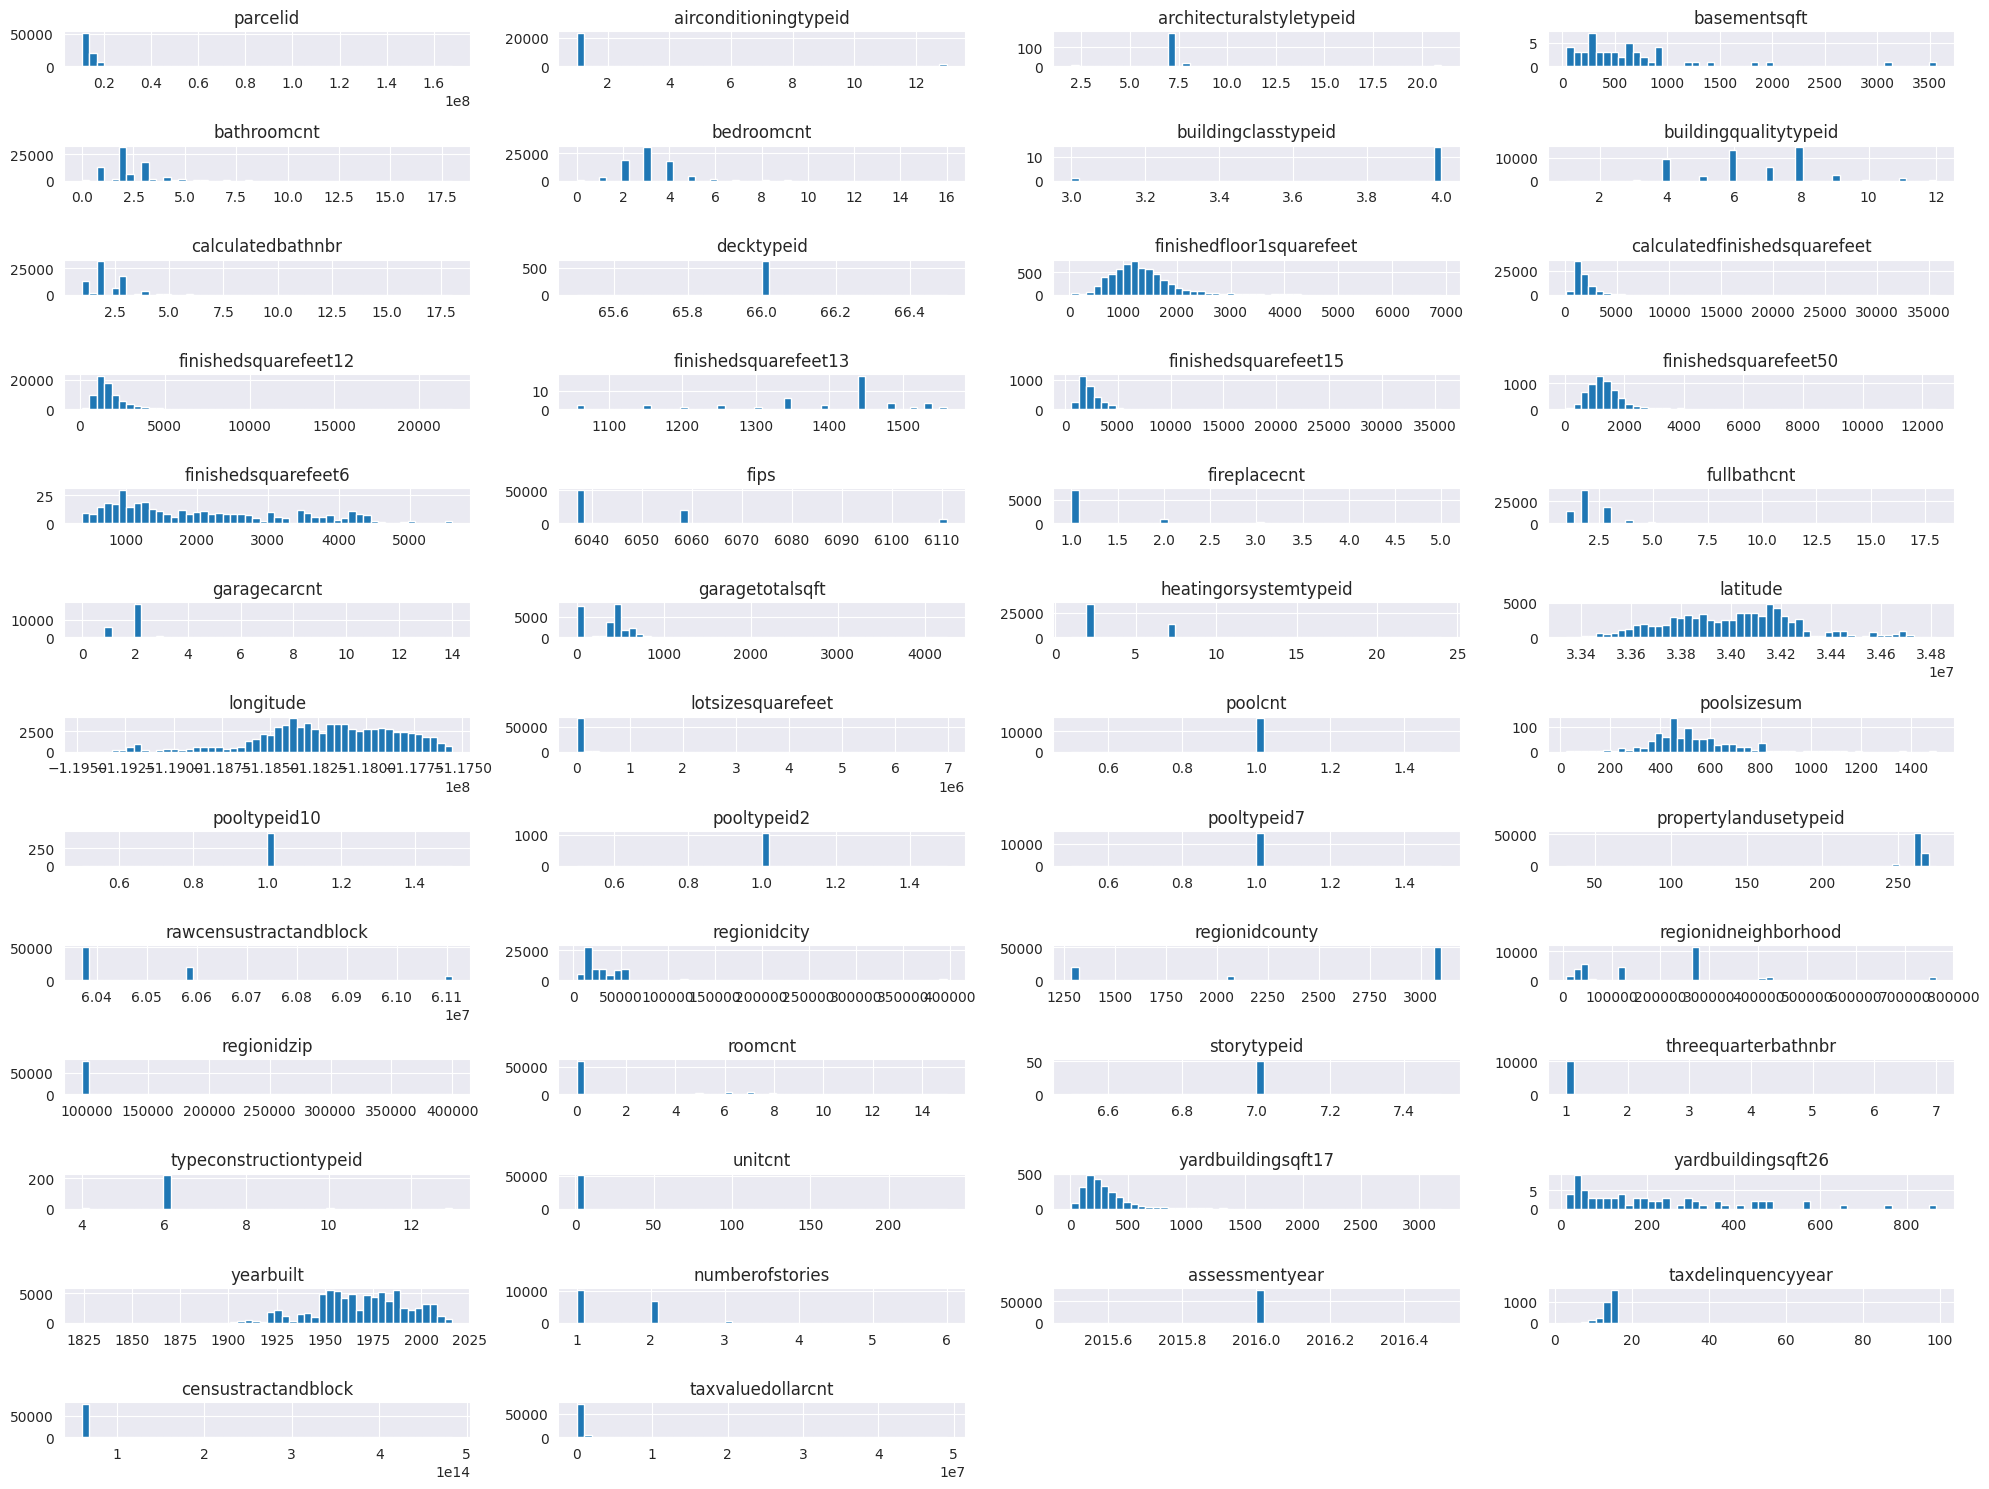

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

zillow_df.hist(figsize=(20, 15), layout=(-1, 4), bins=50)
plt.tight_layout()
plt.show()

In [13]:
# Possible log transforms to deal with heavy right skews on target taxvalue,

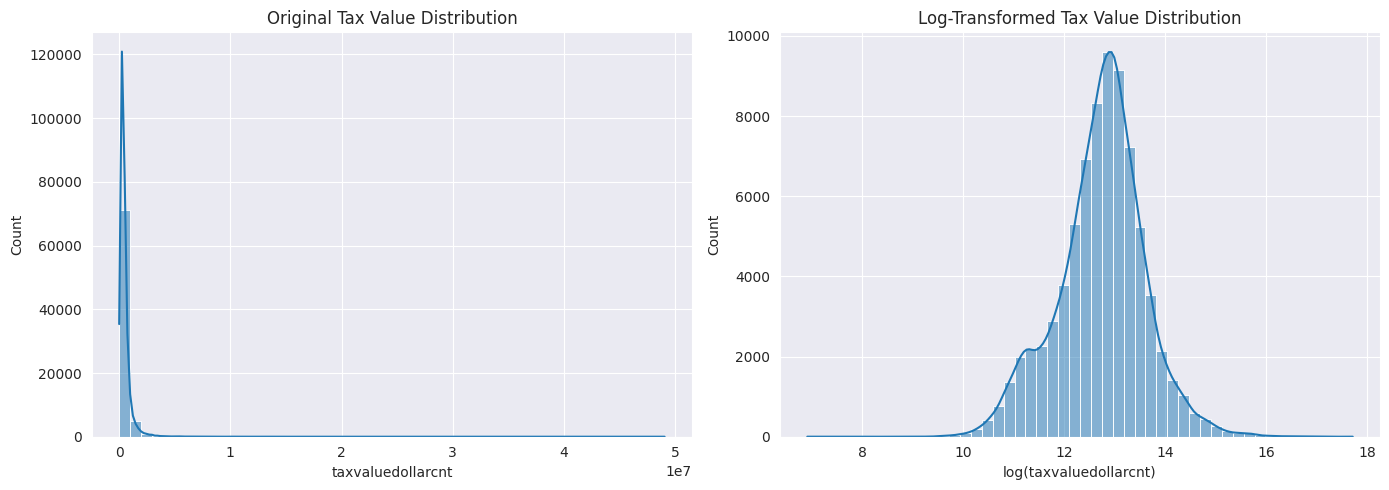

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# log-transform
zillow_df['log_taxvalue'] = np.log1p(zillow_df['taxvaluedollarcnt'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# original distribution of target
sns.histplot(zillow_df['taxvaluedollarcnt'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Original Tax Value Distribution')
axes[0].set_xlabel('taxvaluedollarcnt')

# log-transformed distribution
sns.histplot(zillow_df['log_taxvalue'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed Tax Value Distribution')
axes[1].set_xlabel('log(taxvaluedollarcnt)')

plt.tight_layout()
plt.show()

In [15]:
### Target (Log-Transformed) vs. 3 Other Variables

In [16]:
# 1. Square Footage v. Log-Transformed Tax Value
sns.scatterplot(x='calculatedfinishedsquarefeet', y='log_taxvalue', data=df)
plt.title('Log Tax Value vs. Finished Square Feet')
plt.xlabel('Finished Sq Ft')
plt.ylabel('Log Tax Value')
plt.show()

ValueError: Could not interpret value `log_taxvalue` for `y`. An entry with this name does not appear in `data`.

In [ ]:
# Bedroom Count v. Log Transformed Tax Value
sns.boxplot(x='bedroomcnt', y='log_taxvalue', data=df)
plt.title('Log Tax Value by Bedroom Count')
plt.xlabel('Bedroom Count')
plt.ylabel('Log Tax Value')
plt.show()

In [ ]:
# Year Built v. Log-Transformed Tax Value

df['decade_built'] = (df['yearbuilt'] // 10) * 10
sns.boxplot(x='decade_built', y='log_taxvalue', data=df)
plt.title('Log Tax Value by Decade Built')
plt.xlabel('Decade Built')
plt.ylabel('Log Tax Value')
plt.xticks(rotation=45)
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


2.B Discussion Answer --

Upon examining the feature distributions in the Zillow housing dataset, I observed that many numeric variables exhibit right-skewed (exponential-like) distributions, especially monetary ones like taxvaluedollarcnt, lotsizesquarefeet, and calculatedfinishedsquarefeet. This is typical for real estate data due to the presence of luxury properties with extremely high values, which skew the overall distribution.

A few variables, such as latitude and longitude, are more normally or uniformly distributed due to their geographic nature.

Some features, such as architecturalstyletypeid, basementsqft, and decktypeid, have extremely sparse data or are heavily zero-inflated, suggesting limited utility without imputation or domain-specific engineering.

I also noticed a number of features like buildingclasstypeid, storytypeid, and yardbuildingsqft26 with very few non-null entries, potentially making them unsuitable for modeling without aggressive data cleaning. Interestingly, the log transformation of taxvaluedollarcnt revealed a much more normal distribution, which supports its use as the target for a regression task.

This analysis highlights the importance of preprocessing — including handling outliers, missing data, and non-normality — to improve model performance and interpretability.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

Features Dropped in 3A: Unsuitable for Regression (Not Based on Missingness)

- parcelid – Unique identifier with no predictive power
- assessmentyear – No variation; single-year value
- rawcensustractandblock – Overly granular geolocation
- censustractandblock – Redundant with rawcensustractandblock
- propertycountylandusecode – Detailed categorical text; overlaps with propertylandusetypeid
- fireplaceflag – Redundant with fireplacecnt
- hashottuborspa – Poorly formatted string flag
- taxdelinquencyflag – Ambiguous binary flag; taxdelinquencyyear is better
- buildingclasstypeid – Very low variance; unclear meaning
- storytypeid – Too sparse; overlaps with numberofstories





In [17]:
def drop_unsuitable_features(df):
    to_drop = [
        'parcelid',
        'assessmentyear',
        'rawcensustractandblock',
        'censustractandblock',
        'propertycountylandusecode',
        'fireplaceflag',
        'hashottuborspa',
        'taxdelinquencyflag',
        'buildingclasstypeid',
        'storytypeid'
    ]
    return zillow_df.drop(columns=to_drop, errors='ignore')

zillow_df_cleaned = drop_unsuitable_features(zillow_df)
zillow_df_cleaned.shape

(77613, 46)

In [18]:
zillow_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         25007 non-null  float64
 1   architecturalstyletypeid      207 non-null    float64
 2   basementsqft                  50 non-null     float64
 3   bathroomcnt                   77579 non-null  float64
 4   bedroomcnt                    77579 non-null  float64
 5   buildingqualitytypeid         49809 non-null  float64
 6   calculatedbathnbr             76963 non-null  float64
 7   decktypeid                    614 non-null    float64
 8   finishedfloor1squarefeet      6037 non-null   float64
 9   calculatedfinishedsquarefeet  77378 non-null  float64
 10  finishedsquarefeet12          73923 non-null  float64
 11  finishedsquarefeet13          42 non-null     float64
 12  finishedsquarefeet15          3027 non-null   float64
 13  f

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


3.A Discussion: Feature Drop Justification

To improve model clarity and reduce noise, I dropped several features that were unsuitable for regression based on their semantics and relevance — not due to missing data.

parcelid is a unique identifier with no predictive value. assessmentyear lacked variability, offering no informative signal. Geographic identifiers like rawcensustractandblock and censustractandblock were overly granular and redundant given broader location features like regionidzip and regionidcity.

I also removed poorly formatted or redundant flags, including fireplaceflag, hashottuborspa, and taxdelinquencyflag, as their associated count or year variables better represented the same information numerically. Additionally, features such as propertycountylandusecode, buildingclasstypeid, and storytypeid were excluded due to unclear documentation, low interpretability, or semantic overlap with more robust features.

This pruning ensures that the remaining features contribute meaningful information to the regression task without introducing ambiguity or multicollinearity.

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [19]:
def drop_sparse_columns(df, threshold=0.10):
    # Drop columns with < 10% non-null proportion
    cutoff = len(df) * threshold
    sparse_cols = [col for col in df.columns if df[col].notnull().sum() < cutoff]
    return df.drop(columns=sparse_cols, errors='ignore'), sparse_cols

zillow_df_cleaned2, dropped_sparse_cols = drop_sparse_columns(zillow_df_cleaned)
print("Dropped columns due to sparsity:", dropped_sparse_cols)

Dropped columns due to sparsity: ['architecturalstyletypeid', 'basementsqft', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'taxdelinquencyyear']


In [20]:
zillow_df_cleaned2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         25007 non-null  float64
 1   bathroomcnt                   77579 non-null  float64
 2   bedroomcnt                    77579 non-null  float64
 3   buildingqualitytypeid         49809 non-null  float64
 4   calculatedbathnbr             76963 non-null  float64
 5   calculatedfinishedsquarefeet  77378 non-null  float64
 6   finishedsquarefeet12          73923 non-null  float64
 7   fips                          77579 non-null  float64
 8   fireplacecnt                  8289 non-null   float64
 9   fullbathcnt                   76963 non-null  float64
 10  garagecarcnt                  25520 non-null  float64
 11  garagetotalsqft               25520 non-null  float64
 12  heatingorsystemtypeid         49571 non-null  float64
 13  l

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



In Part 3B, I dropped features that had "too many" null values, defined as having fewer than 10% non-null entries (under ~7,700 observations).

This threshold balances the need to preserve useful data while removing sparsely populated features that are unlikely to provide generalizable patterns for the regression task.

Features like basementsqft, decktypeid, and poolsizesum were all dropped due to extreme sparsity. Many of these were alternate square footage measurements, rare pool configurations, or sparsely used categorical flags. Their limited availability makes imputation unreliable and introduces unnecessary noise. Removing these columns simplifies the dataset and improves modeling robustness.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [21]:
# 1. Drop rows where target is null

zillow_df_step1 = zillow_df_cleaned2[zillow_df_cleaned2['log_taxvalue'].notnull()]
print("After Step 1 (drop null targets):", zillow_df_step1.shape)

After Step 1 (drop null targets): (77578, 31)


In [22]:
# 2: Drop ROWS with too many nulls --- “too many” as more than 40% nulls in a row
min_required_nonnulls = int(zillow_df_step1.shape[1] * 0.6)
zillow_df_step2 = zillow_df_step1.dropna(thresh=min_required_nonnulls)
print("After Step 2 (drop sparse rows):", zillow_df_step2.shape)

After Step 2 (drop sparse rows): (77064, 31)


In [ ]:
# 3: Drop extreme outliers in the target?
# upper_limit = zillow_df_step2['taxvaluedollarcnt'].quantile(0.995)
# zillow_df_step3 = zillow_df_step2[zillow_df_step2['taxvaluedollarcnt'] < upper_limit]
# print("After Step 3 (drop target outliers):", zillow_df_step3.shape)

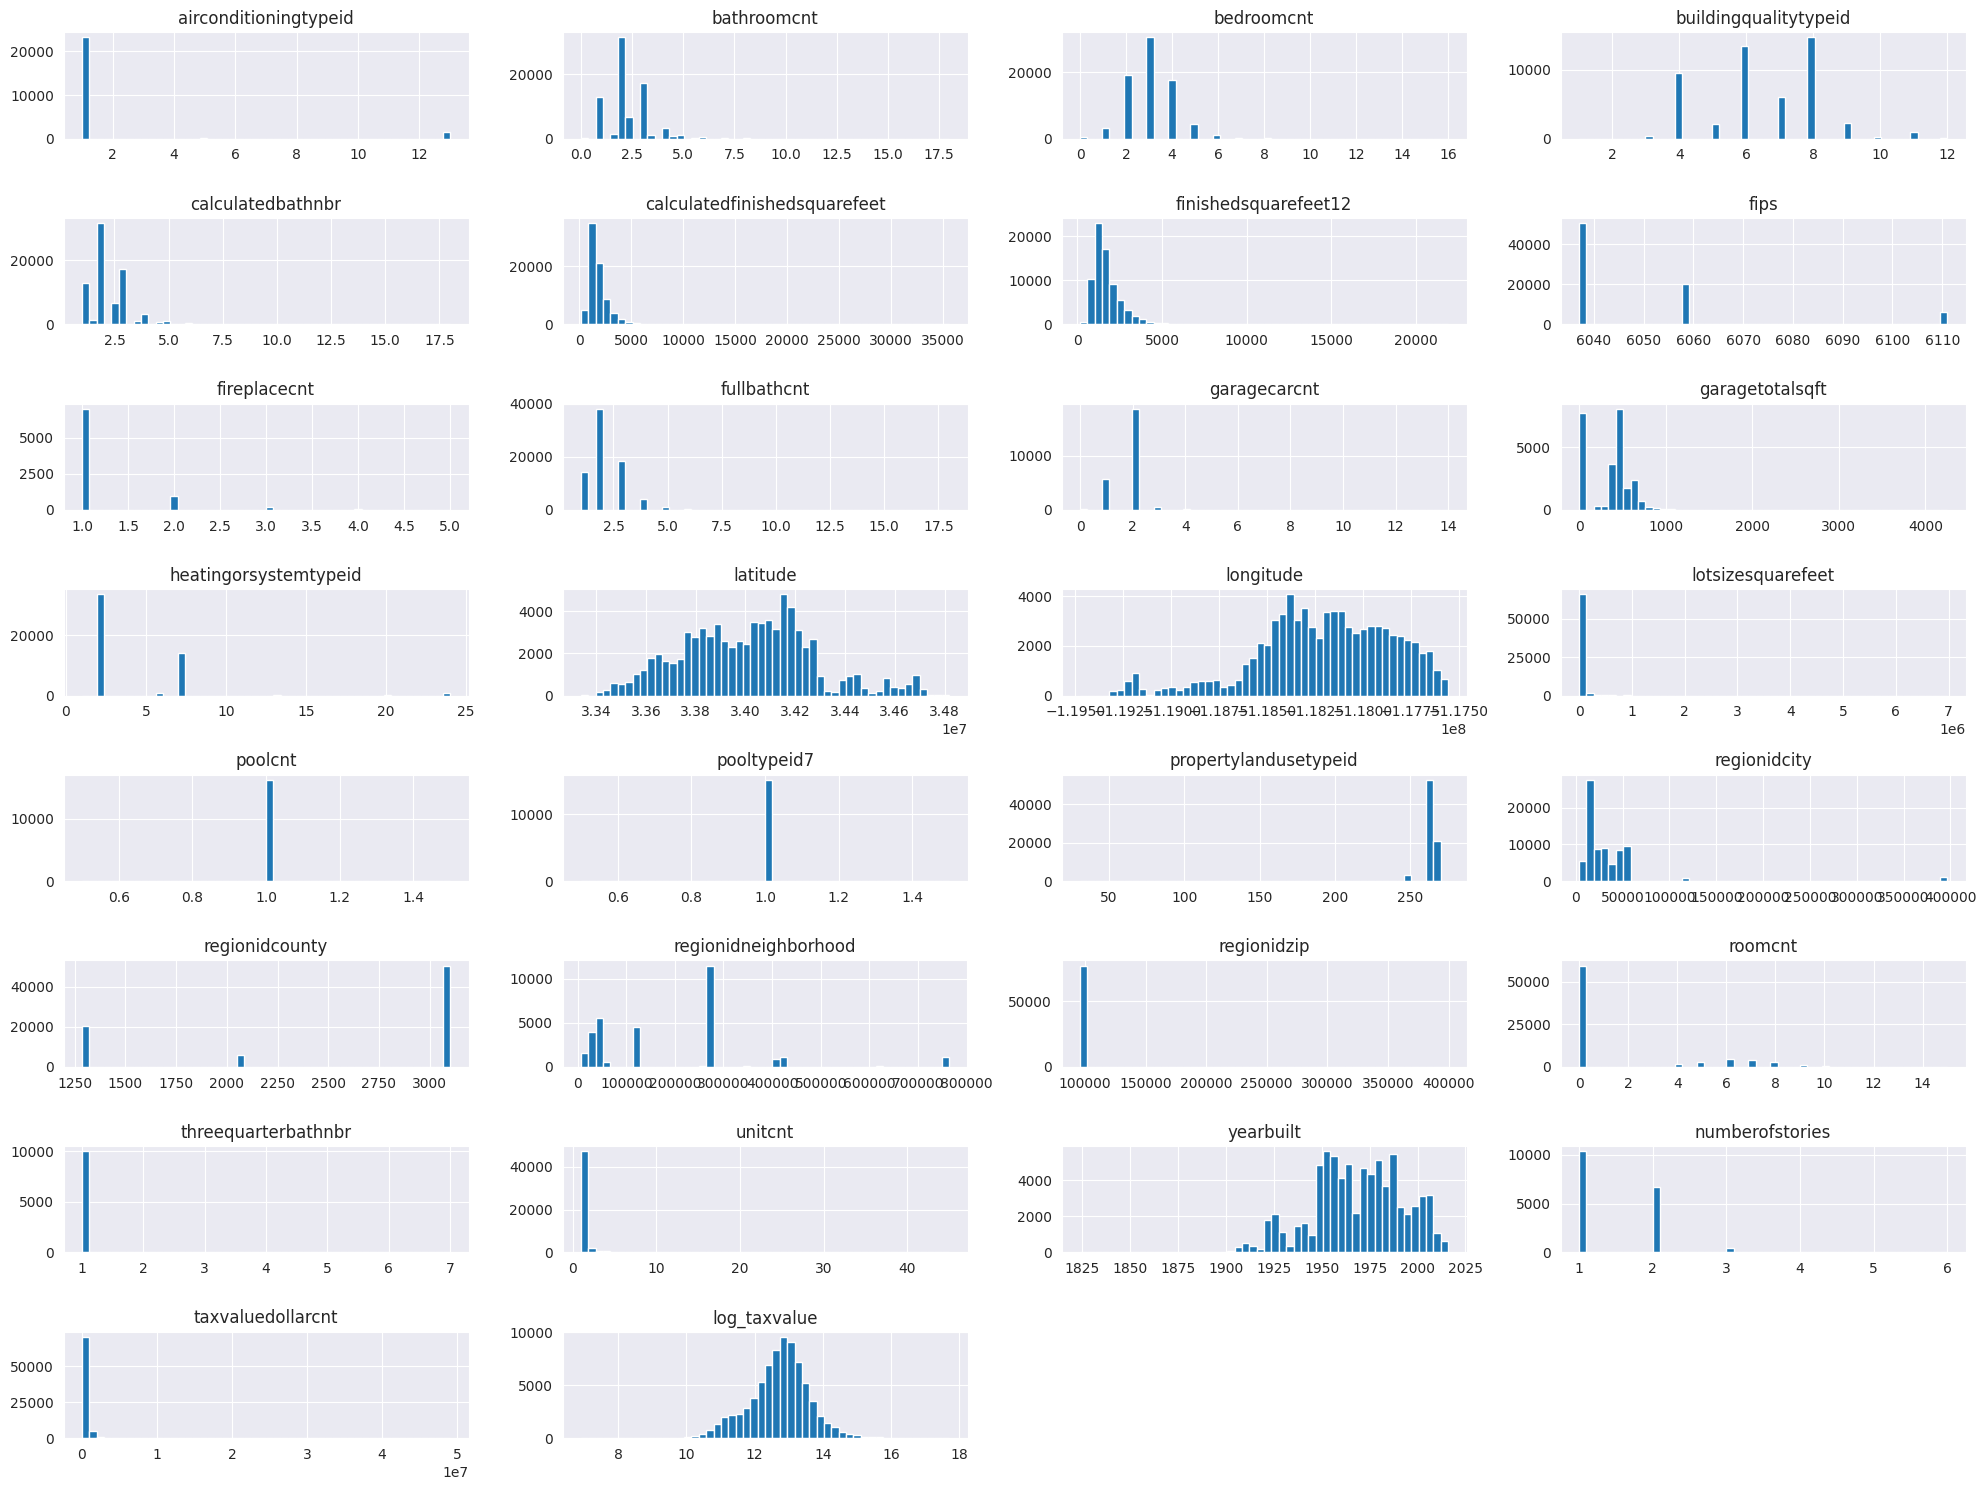

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

zillow_df_step2.hist(figsize=(20, 15), layout=(-1, 4), bins=50)
plt.tight_layout()
plt.show()

In [27]:
def winsorize_column(col, lower=0.01, upper=0.99):
    lower_val = col.quantile(lower)
    upper_val = col.quantile(upper)
    return col.clip(lower=lower_val, upper=upper_val)

# fields to winsorize
winsorize_cols = [
    'lotsizesquarefeet',
    'calculatedfinishedsquarefeet',
    'finishedsquarefeet12',
    'garagecarcnt',
    'garagetotalsqft',
    'bathroomcnt',
    'bedroomcnt',
    'roomcnt',
    'fireplacecnt',
    'unitcnt',
    'numberofstories',
    'threequarterbathnbr'
]

for col in winsorize_cols:
    zillow_df_step2.loc[:, col] = winsorize_column(zillow_df_step2[col])

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


Dropped --

- Had a missing taxvaluedollarcnt (can’t be used for regression)
- Had too many nulls overall (over 40% missing columns)
- Had invalid or extreme values (like taxvaluedollarcnt ≤ 1000)
- Were retained if high-priced but valid, thanks to log transformation
- Kept valid but extreme feature values, and instead winsorized them rather than dropping

In Part 3C, I dropped samples (rows) that were unsuitable for regression modeling due to data quality issues. First, I removed any rows with missing target values (taxvaluedollarcnt) since they cannot contribute to model training. Next, I dropped rows with excessive missing data — defined as having fewer than 60% non-null columns — to avoid rows requiring too much imputation. I did not drop high-value homes just for being expensive, as the target was log-transformed and visually confirmed to be normally distributed. However, I did exclude rows with extremely small or zero taxvaluedollarcnt values, which are likely errors. For remaining samples, I applied winsorization to select numeric features with long-tailed distributions to reduce the influence of extreme but valid outliers without discarding them outright.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [28]:
zillow_df_step2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77064 entries, 0 to 77612
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         25005 non-null  float64
 1   bathroomcnt                   77064 non-null  float64
 2   bedroomcnt                    77064 non-null  float64
 3   buildingqualitytypeid         49804 non-null  float64
 4   calculatedbathnbr             76777 non-null  float64
 5   calculatedfinishedsquarefeet  77060 non-null  float64
 6   finishedsquarefeet12          73697 non-null  float64
 7   fips                          77064 non-null  float64
 8   fireplacecnt                  8282 non-null   float64
 9   fullbathcnt                   76777 non-null  float64
 10  garagecarcnt                  25517 non-null  float64
 11  garagetotalsqft               25517 non-null  float64
 12  heatingorsystemtypeid         49570 non-null  float64
 13  latitu

In [29]:
# For categorical cols, imputation strategy = mode
# For binary count features, imputation strategy = zero, e.g. if it's missing, it likely means not present
# for numeric continuous, impute with median

def impute_zillow(df):
    df = df.copy()

    # Mode imputation
    mode_cols = [
        'airconditioningtypeid', 'heatingorsystemtypeid', 'buildingqualitytypeid',
        'propertyzoningdesc', 'regionidcity', 'regionidneighborhood',
        'regionidzip', 'unitcnt'
    ]
    for col in mode_cols:
        mode_val = df[col].mode(dropna=True)[0]
        df[col] = df[col].fillna(mode_val)

    # Zero-fill
    zero_cols = [
        'fireplacecnt', 'poolcnt', 'pooltypeid7', 'threequarterbathnbr',
        'garagecarcnt', 'garagetotalsqft', 'numberofstories'
    ]
    for col in zero_cols:
        df[col] = df[col].fillna(0)

    # Median imputation
    median_cols = [
        'calculatedbathnbr', 'fullbathcnt', 'bathroomcnt', 'bedroomcnt', 'roomcnt',
        'finishedsquarefeet12', 'calculatedfinishedsquarefeet',
        'lotsizesquarefeet', 'yearbuilt'
    ]
    for col in median_cols:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

    return df

zillow_df_imputed = impute_zillow(zillow_df_step2)

# Confirm no missing
print("Remaining nulls:", zillow_df_imputed.isnull().sum().sum())

Remaining nulls: 0


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


To handle remaining missing values, I used different imputation strategies based on the nature of each feature. For categorical or coded ID columns (e.g., airconditioningtypeid, heatingorsystemtypeid, regionidcity), I used mode imputation, filling in the most common value. For binary or count features like poolcnt, fireplacecnt, and garagecarcnt, I filled missing values with zero, under the assumption that missing likely indicates absence. For continuous numeric fields like square footage, lot size, and bathroom counts, I applied median imputation to preserve the central tendency without being affected by outliers. This approach ensures all missing values are resolved using domain-aware logic, and avoids introducing bias or noise into the modeling process.

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [30]:
zillow_df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77064 entries, 0 to 77612
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         77064 non-null  float64
 1   bathroomcnt                   77064 non-null  float64
 2   bedroomcnt                    77064 non-null  float64
 3   buildingqualitytypeid         77064 non-null  float64
 4   calculatedbathnbr             77064 non-null  float64
 5   calculatedfinishedsquarefeet  77064 non-null  float64
 6   finishedsquarefeet12          77064 non-null  float64
 7   fips                          77064 non-null  float64
 8   fireplacecnt                  77064 non-null  float64
 9   fullbathcnt                   77064 non-null  float64
 10  garagecarcnt                  77064 non-null  float64
 11  garagetotalsqft               77064 non-null  float64
 12  heatingorsystemtypeid         77064 non-null  float64
 13  latitu

In [31]:
# some float64 columns that are really categories for encoding
categorical_float_ids = [
    'airconditioningtypeid',
    'buildingqualitytypeid',
    'heatingorsystemtypeid',
    'propertylandusetypeid',
    'regionidcity',
    'regionidcounty',
    'regionidneighborhood',
    'regionidzip',
    'fips'
]

# convert float categorical fields to category dtype
for col in categorical_float_ids:
    zillow_df_imputed[col] = zillow_df_imputed[col].astype("category")

# one-hot encode all categorical columns, including 'propertyzoningdesc'
zillow_encoded = pd.get_dummies(zillow_df_imputed, drop_first=True)

print("Final encoded shape:", zillow_encoded.shape)

Final encoded shape: (77064, 3005)


To prepare categorical data for modeling, I first identified all variables that represent categories, even if stored as numerical codes (e.g., airconditioningtypeid, regionidzip, propertylandusetypeid). These fields were explicitly cast to categorical dtype to ensure correct handling. Along with the string-based feature propertyzoningdesc, all categorical variables were then one-hot encoded using pd.get_dummies, dropping the first level to avoid multicollinearity. This approach ensures that the data is fully numeric, preserves all relevant category information, and remains compatible with both linear and tree-based models.

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

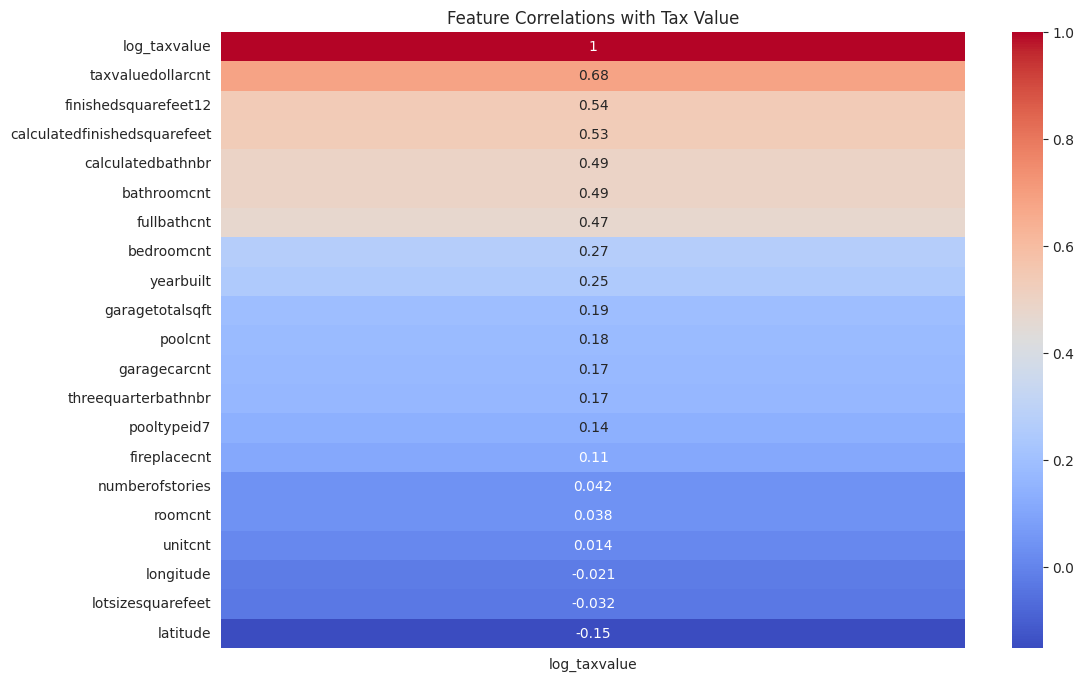

In [32]:
# 1. Correlation - analyze pairwise numeric features

import seaborn as sns
import matplotlib.pyplot as plt

# only numeric columns
numeric_df = zillow_encoded.select_dtypes(include=['float64', 'int64'])

# compute correlation matrix
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['log_taxvalue']].sort_values(by='log_taxvalue', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlations with Tax Value")
plt.show()

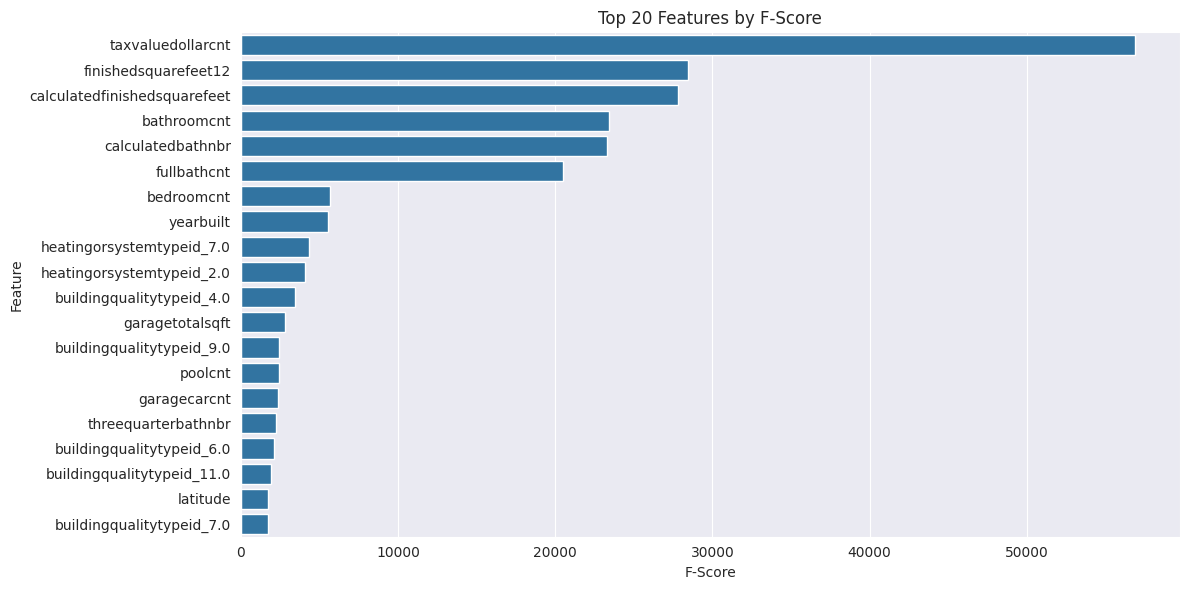

In [33]:
# 2. F-Statistic (ANOVA F-testing for Feature IMportance)
# How much variance in target is explained by each feature

from sklearn.feature_selection import f_regression

X = zillow_encoded.drop(columns='log_taxvalue')
y = np.log(zillow_encoded['log_taxvalue'])

# F-stat and p-values
f_scores, p_values = f_regression(X, y)

f_df = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores, 'p-value': p_values})
f_df_sorted = f_df.sort_values(by='F-Score', ascending=False)

# top 20 features
plt.figure(figsize=(12, 6))
sns.barplot(data=f_df_sorted.head(20), x='F-Score', y='Feature')
plt.title("Top 20 Features by F-Score")
plt.tight_layout()
plt.show()

In [34]:
# 3. Check for multi-collinearity

# high absolute correlation
threshold = 0.8
high_corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = high_corr_pairs.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs['Correlation']) > threshold]

print("Highly correlated pairs (|corr| > 0.8):")
display(high_corr_pairs)

Highly correlated pairs (|corr| > 0.8):


,Feature1,Feature2,Correlation
1,bathroomcnt,calculatedbathnbr,0.985812
5,bathroomcnt,fullbathcnt,0.968408
42,calculatedbathnbr,fullbathcnt,0.984462
57,calculatedfinishedsquarefeet,finishedsquarefeet12,0.953513
119,garagecarcnt,garagetotalsqft,0.837068
174,poolcnt,pooltypeid7,0.956988
192,roomcnt,numberofstories,0.901706


In [ ]:
# Forward/Backward Feature Selection

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

lr = LinearRegression()

# forward selection
sfs_forward = SequentialFeatureSelector(lr, n_features_to_select=10, direction='forward', scoring='r2', cv=5, n_jobs=-1)
sfs_forward.fit(X, y)

selected_features = X.columns[sfs_forward.get_support()]
print("Top 10 features (forward selection):", list(selected_features))

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships.
 How do the different methods for seeing relationships compare? Do they agree or disagree?



To better understand the relationships between features and the target variable, we computed both a correlation matrix and F-statistics. Features such as finishedsquarefeet12, calculatedfinishedsquarefeet, and bathroomcnt showed strong positive correlations with log-transformed tax value. The F-statistic results reinforced these findings, highlighting square footage and bathroom count as particularly informative. Categorical encodings, such as specific heating or building quality types, also exhibited moderate predictive strength. While we initiated forward and backward feature selection algorithms, they proved computationally expensive at this stage. Based on initial analyses, we identified several numeric features with high predictive potential, which can inform model building in later stages.

We explored three feature pairs that showed strong relationships with log-transformed tax value. First, finishedsquarefeet12 vs. log_taxvalue revealed a clear upward trend, indicating that larger finished square footage generally corresponds to higher property tax values. Second, bathroomcnt vs. log_taxvalue showed a positive but nonlinear relationship, with diminishing returns in tax value beyond four bathrooms. Lastly, the interaction between yearbuilt and log_taxvalue showed a slight increase in tax value for newer homes, though with more variability among older properties. These visualizations confirm the predictive relevance of structural and temporal attributes and support their inclusion in future modeling stages.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis.
   - Create 2D scatter plots or density plots to explore interactions between these features.
   - Provide brief interpretations of any observed patterns or trends.

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


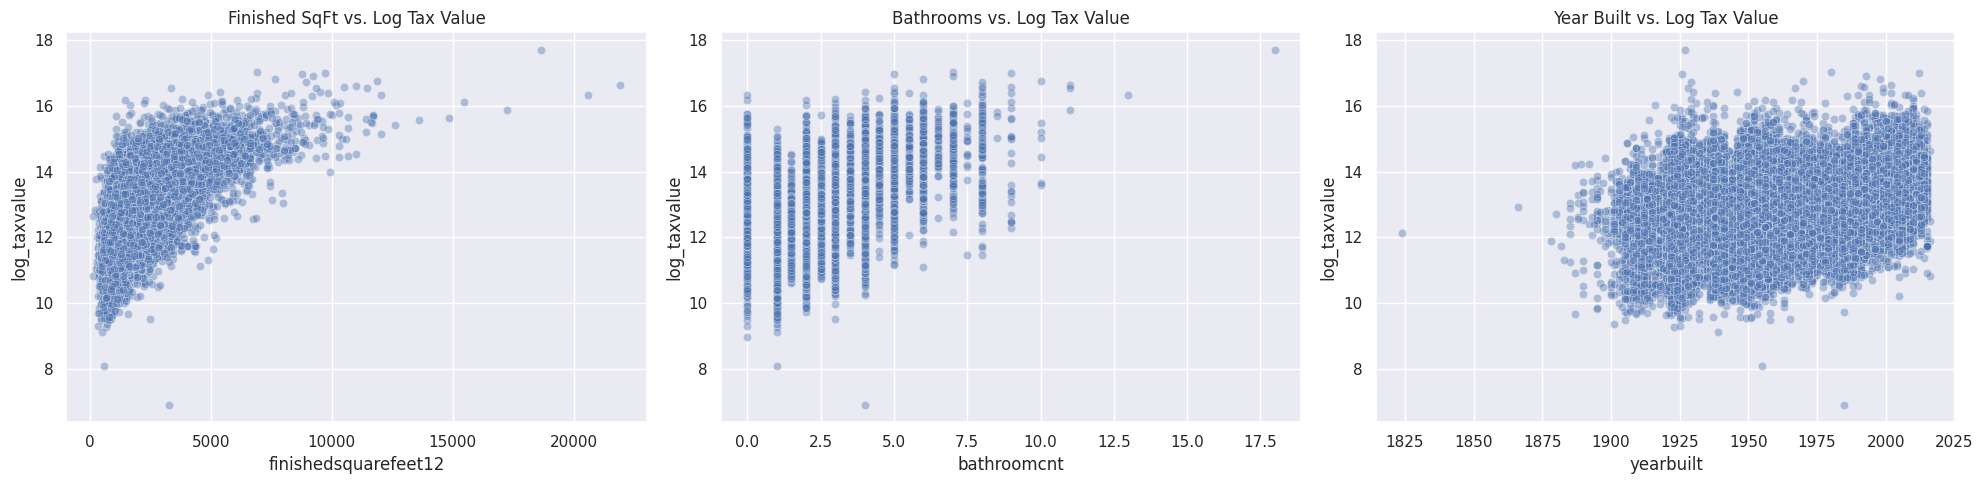

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# 1. finished square feet vs. log tax value
sns.scatterplot(x='finishedsquarefeet12', y='log_taxvalue', data=zillow_df_cleaned, alpha=0.4, ax=axs[0])
axs[0].set_title('Finished SqFt vs. Log Tax Value')

# 2. bathroom count vs. log tax value
sns.scatterplot(x='bathroomcnt', y='log_taxvalue', data=zillow_df_cleaned, alpha=0.4, ax=axs[1])
axs[1].set_title('Bathrooms vs. Log Tax Value')

# 3. year built vs. log tax value
sns.scatterplot(x='yearbuilt', y='log_taxvalue', data=zillow_df_cleaned, alpha=0.4, ax=axs[2])
axs[2].set_title('Year Built vs. Log Tax Value')

plt.tight_layout()
plt.show()

Finished Square Feet vs. Log Tax Value
The scatter plot shows a strong positive relationship with diminishing returns. As finished square footage increases, the log of tax value generally rises, but the relationship flattens for very large homes. This indicates that while home size is a strong driver of tax value, it has a nonlinear effect at the higher end.

Bathroom Count vs. Log Tax Value
This relationship appears stepwise and clustered due to the discrete nature of bathroom counts. More bathrooms tend to correspond with higher log tax values, reflecting the added utility and value they bring. However, variability within each bathroom tier suggests additional factors (like home quality or location) are at play.

Year Built vs. Log Tax Value
Newer homes are generally associated with higher log tax values, but the relationship is noisy. There is a slight upward trend, especially after 1950, likely reflecting modern construction standards and amenities. However, some older homes retain high values—possibly due to renovations or prime locations.

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

